# Menu <a class="anchor" id="menu"></a>
   
* [1. Introduction au Topic Modelling](#introduction)
* [2. Analyses Exploratoires des jeux de donn√©es](#EDA)
    * [2.1 yelp_academic_dataset_**business**.json](#EDA_business)
    * [2.2 yelp_academic_dataset_**review**.json](#EDA_reviews)
    * [2.3 Pr√©paration du jeu de donn√©es de travail](#data_work)
    * [2.4 Analyses du nouveau jeu de donn√©es](#multivariate_analysis)
* [3. Pr√©traitement des donn√©es](#pretraitement)
    * [3.1 Tokenization](#tokenize)
    * [3.2 Filtrage des tokens](#filter)
    * [3.3 Lemmatization des tokens](#lemmatize)
    * [3.4 Suppression des mots les plus fr√©quents](#most_frequents)
    * [3.5 Cr√©ation du Dictionnaire](#dict)
    * [3.6 Cr√©ation du Corpus Bag-Of-Words](#corpus_bow)
    * [3.7 Cr√©ation du Corpus TF-IDF](#corpus_tfidf)
    * [3.8 Cr√©ation du Corpus Word2Vec](#corpus_word2vec)
* [4. Topic Modelling avec LDA](#lda_topic_modelling)
    * [4.1 Latent Dirichlet Allocation *(LDA)*](#lda)
    * [4.2 Recheche du nombre de sujets avec le score de coh√©rence](#lda_coherence)
* [5. Topic Modelling avec NMF](#nmf_topic_modelling)
    * [5.1 Negative Matrix Factorisation *(NMF)*](#nmf)
    * [5.2 Recheche du nombre de sujets avec le score de coh√©rence](#nmf_coherence)
* [6. Choix et entrainement du mod√®le final](#final_model)
    * [6.1 Entrainement & interpr√©tation du meilleur mod√®le LDA](#final_model_lda)
        * [Visualisation du mod√®le LDA](#final_model_lda_vis)
    * [6.2 Entrainement & interpr√©tation du meilleur mod√®le NMF](#final_model_nmf)
        * [Visualisation du mod√®le NMF](#final_model_nmf_vis)
    * [6.3 Export du mod√®le s√©lectionn√©](#final_model_export)

---
---
# 1. Introduction au Topic Modelling <a class="anchor" id="introduction"></a> [‚á™](#menu)

Un algorithme de topic modelling est un mod√®le math√©matique/statistique utilis√© pour d√©duire quels sont les sujets qui repr√©sentent le mieux les donn√©es.

Il est bas√©e sur les hypoth√®ses suivantes :
- Un texte (document) est compos√© de plusieurs sujets.
- Un sujet est compos√© d'une collection de mots

Le but de l'algorithme est de calculer une *note* de participation √† un th√®me donn√© pour chaque mot d'un texte, et pour y parvenir nous allons suivre les √©tapes ci-dessous:

<img src="medias/steps.png" width="700">

- **Step1** : consiste √† *r√©cup√®rer les donn√©es* et √† *conduire une Analyse Exploratoire des donn√©es*.
- **Step2** : consiste √† *tokeniser* les textes *(c'est √† dire d√©couper les phrases mot √† mot)* et √©ventuellement √† filtrer ces tokens.
- **Step3** : consiste √† *cr√©er un dictionnaire associant chaque mot √† un ID unique* puis √† *cr√©er un corpus des Bag Of Words* repr√©sentant la fr√©quence des tokens dans chaque reviews *(ou un autre corpus du type TF-IDF ou Word2Vec...)*.
- **Step4** : consiste √† *construire un mod√®le permettant d'identifier les sujets* puis √† l'ajuster pour *trouver le nombre optimal de sujets*.
- **Step5** : consiste √† *utiliser le mod√®le cr√©e* pour connaitre la distribution des sujets identifi√©s dans les *(potentiellement nouveaux)* documents.

In [2]:
import os
import sys
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis.gensim_models

import spacy
import spacy_fastlang
from spacy.tokens import DocBin
from collections import Counter
from pprint import pprint
from tqdm import tqdm
# from tqdm.notebook import tqdm

random_seed = 0
np.random.seed(random_seed)

LOAD_TOKENS_FROM_FILE = True
TOKENS_PATH = os.path.join("data", "tokens.bin")

cmap_ref = 'nipy_spectral'


import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# warnings.filterwarnings("ignore", message=".*the imp module is deprecated in favour of importlib;(.|\n)*") # supports regular expressions

---
---
# 2. Analyses Exploratoires <a class="anchor" id="EDA"></a> [‚á™](#menu)

Le jeu de donn√©es propos√© par Yelp propose de nombreux documents, mais tous ne sont pas pertinents pour notre projet...

Nous allons donc nous int√©resser aux reviews laiss√©es par les utilisateurs *(yelp_academic_dataset_review.json)* et aux entreprises r√©pertori√©es *(yelp_academic_dataset_business.json)*, mais pas aux utilisateurs eux m√™me ou √† d'autres informations disponibles dans les autres fichiers.

In [3]:
def get_num_lines(path):
    with open(path) as f:
        for i, _ in enumerate(f):
            pass
    return i+1

## 2.1 `yelp_academic_dataset_business.json` <a class="anchor" id="EDA_business"></a> [‚á™](#menu)

En √©tudiant ce jeu de donn√©es, je souhaite d√©couvir si toutes les reviews disponibles sont associ√©es √† des entreprises qui correspondent √† ce que l'on recherche (des restaurants). Si ce n'est pas le cas, il faudra trouver un moyen d'isoler les reviews qui sont pertinentes pour notre projet.

In [4]:
file_path = os.path.join("data", "yelp_dataset", "yelp_academic_dataset_business.json")
data_business = pd.read_json(file_path, lines=True)  # 150346 x 14
display(data_business.head(2), data_business.shape)

business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   

                               attributes  \
0           {'ByAppointmentOnly': 'True'}   
1  {'BusinessAcceptsCreditCards': 'True'}   

                                          categories  \
0  Doctors, Traditional Chinese Medicine, Naturop...   
1  Shipping Centers, Local Services, Notaries, Ma...   

                                               hours  
0                                               None  
1  {'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...

(150346, 14)

In [5]:
data_business.categories.value_counts()

Beauty & Spas, Nail Salons                                                                                       1012
Restaurants, Pizza                                                                                                935
Nail Salons, Beauty & Spas                                                                                        934
Pizza, Restaurants                                                                                                823
Restaurants, Mexican                                                                                              728
                                                                                                                 ... 
Dermatologists, Health & Medical, Cosmetic Surgeons, Doctors, Acne Treatment, Skin Care, Beauty & Spas              1
Home Services, Home & Garden, Nurseries & Gardening, Hardware Stores, Shopping, Building Supplies, Appliances       1
Food Trucks, Smokehouse, Restaurants, Food, Barbeque, So

In [6]:
data_business.categories.str.contains('Restaurant').value_counts(dropna=False)

False    97957
True     52286
None       103
Name: categories, dtype: int64

>#### Il y a visiblement beaucoup de commerces qui ne sont pas des restaurants... on va donc devoir trouver un moyen d'isoler les reviews qui concernent les restaurants.

### Pr√©paration d'un jeu de donn√©es regroupants les business qui sont des restaurants

In [7]:
data_restaurant = data_business[data_business.categories.str.contains("Restaurant") == True]
display(data_restaurant.head(2), data_restaurant.shape)

business_id                name        address          city  \
3  MTSW4McQd7CbVtyjqoe9mw  St Honore Pastries    935 Race St  Philadelphia   
5  CF33F8-E6oudUQ46HnavjQ      Sonic Drive-In  615 S Main St  Ashland City   

  state postal_code   latitude  longitude  stars  review_count  is_open  \
3    PA       19107  39.955505 -75.155564    4.0            80        1   
5    TN       37015  36.269593 -87.058943    2.0             6        1   

                                          attributes  \
3  {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
5  {'BusinessParking': 'None', 'BusinessAcceptsCr...   

                                          categories  \
3  Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
5  Burgers, Fast Food, Sandwiches, Food, Ice Crea...   

                                               hours  
3  {'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...  
5  {'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...

(52286, 14)

### Supprimons ceux qui font √©galement Hotel car c'est un th√®me assez fort qui risque de prendre le pas sur la Restauration

In [8]:
data_restaurant = data_restaurant[data_restaurant.categories.str.contains("Hotel") == False]
display(data_restaurant.head(2), data_restaurant.shape)

business_id                name        address          city  \
3  MTSW4McQd7CbVtyjqoe9mw  St Honore Pastries    935 Race St  Philadelphia   
5  CF33F8-E6oudUQ46HnavjQ      Sonic Drive-In  615 S Main St  Ashland City   

  state postal_code   latitude  longitude  stars  review_count  is_open  \
3    PA       19107  39.955505 -75.155564    4.0            80        1   
5    TN       37015  36.269593 -87.058943    2.0             6        1   

                                          attributes  \
3  {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
5  {'BusinessParking': 'None', 'BusinessAcceptsCr...   

                                          categories  \
3  Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
5  Burgers, Fast Food, Sandwiches, Food, Ice Crea...   

                                               hours  
3  {'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...  
5  {'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...

(51864, 14)

---
>#### `TODO`  done ‚úÖ | todo ‚ùå |
> - ‚úÖ Il faut filtrer les reviews en utilisant data_restaurant pour ne conserver que celles qui sont li√©s √† la restauration *(qui est notre sujet)*
<br><u>*(action: fait ci-dessous)*</u>

## 2.2 `yelp_academic_dataset_review.json` <a class="anchor" id="EDA_reviews"></a> [‚á™](#menu)
En √©tudiant ce jeu de donn√©es, je souhaite d√©couvrir un moyen de s√©parer les commentaires positifs des commentaires n√©gatifs *(qui sont ceux qui nous int√©ressent pour pouvoir identifier les sujets d'insatisfaction)*

In [9]:
file_path = os.path.join("data", "yelp_dataset", "yelp_academic_dataset_review.json")
data_review = pd.read_json(file_path, lines=True, nrows=1000000)  # 6990280 x 9
display(data_review.head(2), data_review.shape)

review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   

   stars  useful  funny  cool  \
0      3       0      0     0   
1      5       1      0     1   

                                                text                date  
0  If you decide to eat here, just be aware it is... 2018-07-07 22:09:11  
1  I've taken a lot of spin classes over the year... 2012-01-03 15:28:18

(1000000, 9)

In [10]:
(get_num_lines(file_path), data_review.shape[1])

(6990280, 9)

### Regardons plus en d√©tails les variables du jeu de donn√©es

#### Les variables qualitatives

In [11]:
data_review.describe(exclude=['number','datetime']).T

count   unique  \
review_id    1000000  1000000   
user_id      1000000   542003   
business_id  1000000    27095   
text         1000000   998357   

                                                           top  freq  
review_id                               KU_O5udG6zpxOg-VcAEodg     1  
user_id                                 _BcWyKQL16ndpBdggh2kNA   483  
business_id                             GBTPC53ZrG1ZBY3DT8Mbcw  4661  
text         I have eaten at just about every decent Indian...     5

#### Les variables quantitatives

In [12]:
data_review.describe(datetime_is_numeric=True).T

count                           mean                  min  \
stars   1000000.0                       3.783959                  1.0   
useful  1000000.0                       1.106594                  0.0   
funny   1000000.0                       0.307812                  0.0   
cool    1000000.0                       0.457129                  0.0   
date      1000000  2016-07-13 10:09:02.464016128  2005-03-01 17:47:15   

                               25%                  50%  \
stars                          3.0                  4.0   
useful                         0.0                  0.0   
funny                          0.0                  0.0   
cool                           0.0                  0.0   
date    2014-08-07 16:29:16.500000  2016-10-11 16:02:42   

                                  75%                  max       std  
stars                             5.0                  5.0  1.440197  
useful                            1.0                539.0  2.848906  
funny                             0.0                284.0  1.428185  
cool                              0.0                172.0  1.799114  
date    2018-09-01 01:26:22.249999872  2022-01-19 19:47:59       NaN

>#### Le meilleur moyen de s√©parer les bons des mauvais commentaires semble donc √™tre de s'appuyer sur la colonne `stars`.
> Nous pourrions binariser les reviews en associant les notes inf√©rieures √† 2.5 √† une mauvaise review et celles sup√©rieures √† 2.5 √† une bonne review.<br>Mais pour √©viter les commentaires trop neutres entre les deux, on ne va garder que les notes de 1 et 2 comme indicateur d'insatisfaction.

---
>#### `TODO`  done ‚úÖ | todo ‚ùå |
> - ‚úÖ Il faut binariser les reviews pour ne garder que les mots li√©s √† l'instatisfaction.
<br><u>*(action: fait en fin de partie 2.4)*</u>

## 2.3 Pr√©paration du jeu de donn√©es de travail <a class="anchor" id="data_work"></a> [‚á™](#menu)

### Supprimons les reviews qui ne concernent pas des restaurants et gardons uniquement les colonnes utiles pour la suite

In [13]:
join_restaurant_reviews = data_review.merge(data_restaurant, on='business_id', how='left')

In [14]:
join_restaurant_reviews.categories.value_counts(dropna=False)

NaN                                                                                                                                   322628
Restaurants, Mexican                                                                                                                    7915
Mexican, Restaurants                                                                                                                    6219
Restaurants, Pizza                                                                                                                      4760
German, Restaurants, Seafood, Cocktail Bars, French, Brasseries, American (New), Nightlife, Bars, Cajun/Creole, Breakfast & Brunch      4661
                                                                                                                                       ...  
Imported Food, Restaurants, Mexican, Breakfast & Brunch, Food, Specialty Food, Ethnic Food                                                 1
Cafes, Coffee

In [15]:
data_review_restos = join_restaurant_reviews[['stars_x', 'text', 'user_id', 'business_id', 'review_id']][join_restaurant_reviews.categories.notnull()]
data_review_restos.rename(columns={'stars_x':'stars'}, inplace=True)
display(data_review_restos.head(2), data_review_restos.shape)

stars                                               text  \
0      3  If you decide to eat here, just be aware it is...   
2      3  Family diner. Had the buffet. Eclectic assortm...   

                  user_id             business_id               review_id  
0  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw  KU_O5udG6zpxOg-VcAEodg  
2  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A  saUsX_uimxRlCVr67Z4Jig

(677372, 5)

### Supprimons les √©ventuels reviews sans texte

In [16]:
data_review_restos.text.isnull().sum()

0

>#### Il n'y a donc pas de reviews sans texte (comme nous l'avions d√©j√† vu avec les describes)

### Supprimons les √©ventuels doublons

#### V√©rifions tout d'abord si l'on a des doublons sur la base des colonnes que nous avons gard√©s

In [17]:
data_review_restos.duplicated().sum()

0

>#### Il n'y a donc pas de doublons si l'on garde toutes les colonnes

#### Mais il se pourrait que chaque review ait bien un ID unique alors que l'on a plusieurs fois les m√™mes textes par un m√™me client sur le m√™me restaurant...

In [18]:
subset = ['stars', 'text', 'user_id', 'business_id']
data_review_restos.duplicated(subset=subset).sum()

987

#### Comparons quelque uns de ces duplicatas pour v√©rifier...

In [19]:
data_review_restos[data_review_restos.duplicated(subset=subset, keep='first')].sort_values('text').head()

stars                                               text  \
586767      5  "Prep's Breakfast Sammie" is the BEST breakfas...   
416542      2  "We ran out of bread" they said, as we drove o...   
460249      1  "Who's in the kitchen and why can't they do th...   
202235      2  2 stars for cheap drinks. I was happy to see t...   
684442      1  20 minutes and no server. Owner finally took a...   

                       user_id             business_id               review_id  
586767  Xf5hPJl9P4r9rRAy-NR46g  UCMSWPqzXjd7QHq7v8PJjQ  Oz8E7WQ5JVlrCC6-PGdY8Q  
416542  oUzXQqxXkFGL5k1OEmFr4g  34Eqv8jXgxg_EEwcsNgeeg  CF4rf7--EneYMVHAPgX7Jg  
460249  CL5U0V87_Ord4cp9pE40Pw  XQfwVwDr-v0ZS3_CbbE5Xw  PnqDAlcL2-S9oOgn34Lzkw  
202235  ce9ZWyllsjOGHtdu6NpZww  4yKv0SEpuJDHECFinhifWQ  r_FsYzzKJG4wCgebF7e_sQ  
684442  dTY6QRU-ox_HqX1A7I88tw  Ea2hPSFazxXITET4f6ZJhw  VNMwljSo3CGUwdiUQSukPg

In [20]:
data_review_restos[data_review_restos.duplicated(subset=subset, keep='last')].sort_values('text').head()

stars                                               text  \
498137      5  "Prep's Breakfast Sammie" is the BEST breakfas...   
322765      2  "We ran out of bread" they said, as we drove o...   
60045       1  "Who's in the kitchen and why can't they do th...   
134308      2  2 stars for cheap drinks. I was happy to see t...   
371454      1  20 minutes and no server. Owner finally took a...   

                       user_id             business_id               review_id  
498137  Xf5hPJl9P4r9rRAy-NR46g  UCMSWPqzXjd7QHq7v8PJjQ  uZ0nZRQ-RpttoLCym2DyHw  
322765  oUzXQqxXkFGL5k1OEmFr4g  34Eqv8jXgxg_EEwcsNgeeg  mSKC9E97PpwdB3L3Jnxc2A  
60045   CL5U0V87_Ord4cp9pE40Pw  XQfwVwDr-v0ZS3_CbbE5Xw  241ycTAVakh4sY8b7S_jyQ  
134308  ce9ZWyllsjOGHtdu6NpZww  4yKv0SEpuJDHECFinhifWQ  z2Cl4obOdxpC1uDnnsdnQw  
371454  dTY6QRU-ox_HqX1A7I88tw  Ea2hPSFazxXITET4f6ZJhw  SdHOvSqwRRZHaX-ON8QEmw

#### On a effectivement quelques doublons qu'il vaudrait mieux nettoyer pour √©viter de mettre plus de poids sur certains mots

In [21]:
print("AVANT:", data_review_restos.shape)
data_review_restos.drop_duplicates(subset=subset, inplace=True)
print("APR√àS:", data_review_restos.shape)

AVANT: (677372, 5)
APR√àS: (676385, 5)


#### Enfin supprimons les colonnes qui ne servaient qu'√† v√©rifier la pr√©sence de doublons

In [22]:
data_review_restos = data_review_restos[['stars', 'text']]

## 2.4 Analyses du nouveau jeu de donn√©es <a class="anchor" id="multivariate_analysis"></a> [‚á™](#menu)

#### Les variables qualitatives

In [23]:
data_review_restos.describe(exclude=['number','datetime']).T

count  unique                                                top freq
text  676385  676228  At the height of the Omicron surge, Wendy's DO...    4

#### Les variables quantitatives

In [24]:
data_review_restos.describe(datetime_is_numeric=True).T

count      mean       std  min  25%  50%  75%  max
stars  676385.0  3.807592  1.366187  1.0  3.0  4.0  5.0  5.0

### R√©partition de la taille des reviews

In [25]:
def plot_review_sizes(data):
    select = pd.DataFrame(data.review_size.value_counts()).reset_index()
    select.sort_values(by='index', inplace=True)
    select.set_index('index', inplace=True)

    review_size_mean = data.review_size.mean()
    review_size_median = data.review_size.median()

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(2,2,1)
    sns.lineplot(data=select, y='review_size', x='index')
    plt.plot([review_size_mean,review_size_mean],[0,10000], label=f"Moyenne ({review_size_mean:.2f})", alpha=0.5)
    plt.plot([review_size_median,review_size_median],[0,10000], label=f"M√©diane ({review_size_median:.2f})", alpha=0.5)
    plt.title("R√©partition des reviews en fonction du nombre de mots")
    plt.xlabel("Nombre de mots")
    plt.ylabel("Nombre de reviews")
    #plt.ylim(0,10000)
    plt.legend()

    plt.subplot(2,2,2)
    zoom_left, zoom_right = 0, 150
    sns.lineplot(data=select[zoom_left:zoom_right], y='review_size', x='index')
    plt.plot([review_size_mean,review_size_mean],[0,10000], label=f"Moyenne ({review_size_mean:.2f})", alpha=0.5)
    plt.plot([review_size_median,review_size_median],[0,10000], label=f"M√©diane ({review_size_median:.2f})", alpha=0.5)
    plt.title(f"R√©partition des reviews en fonction du nombre de mots (zoom {zoom_left} √† {zoom_right} mots)")
    plt.xlabel("Nombre de mots")
    plt.ylabel("Nombre de reviews")
    #plt.ylim(0,10000)
    plt.legend()

    select2 = np.cumsum(select)

    plt.subplot(2,2,3)
    sns.lineplot(data=select2, y='review_size', x='index')
    #plt.plot([xxx,xxx],[0,10000], label="Moyenne", alpha=0.5)
    plt.title("R√©partition cumul√©e des reviews en fonction du nombre de mots")
    plt.xlabel("Nombre de mots")
    plt.ylabel("Nombre de reviews")

    plt.subplot(2,2,4)
    zoom_left, zoom_right = 0, 20
    sns.lineplot(data=select2[zoom_left:zoom_right], y='review_size', x='index')
    plt.title(f"R√©partition cumul√©e des reviews en fonction du nombre de mots (zoom {zoom_left} √† {zoom_right} mots)")
    plt.xlabel("Nombre de mots")
    plt.ylabel("Nombre de reviews")

    plt.tight_layout()
    plt.show()

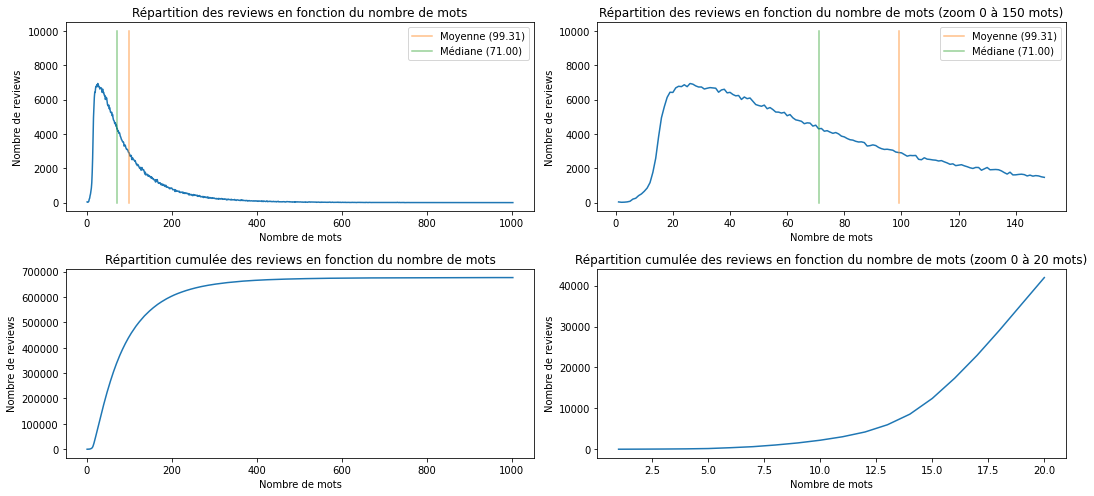

In [26]:
data_tmp = data_review_restos.copy()
data_tmp['review_size'] = data_review_restos.text.apply(lambda x: len(x.split()))
plot_review_sizes(data_tmp)

In [27]:
data_tmp.review_size.describe()

count    676385.000000
mean         99.309070
std          91.630058
min           1.000000
25%          39.000000
50%          71.000000
75%         127.000000
max        1003.000000
Name: review_size, dtype: float64

In [28]:
data_tmp[ data_tmp.review_size > 457 ].shape

(6530, 3)

>#### On constate que :
> - la moiti√© des reviews ont moins de 75 "mots"
> - 48 des 1.000.000 de reviews ont 1 "mot"...
> - 275 des 1.000.000 de reviews ont 5 "mots" ou moins.
> - environ 800.000 des 1.000.000 de reviews ont moins de 150 "mots"

---
>#### `TODO`  done ‚úÖ | todo ‚ùå |
> - ‚úÖ Il faut supprimer les outliers. Ils risquent d'utiliser des mots non r√©pr√©sentatifs.
<br><u>*(action: fait ci-dessous)*</u>

#### Supprimons les outliers avec trop de textes et qui risquent donc d'utiliser des mots non repr√©sentatifs

In [29]:
data_clean = data_tmp[ data_tmp.review_size < data_tmp.review_size.quantile(0.99)]
display(data_clean.head(2), data_clean.shape)

stars                                               text  review_size
0      3  If you decide to eat here, just be aware it is...          101
2      3  Family diner. Had the buffet. Eclectic assortm...           55

(669615, 3)

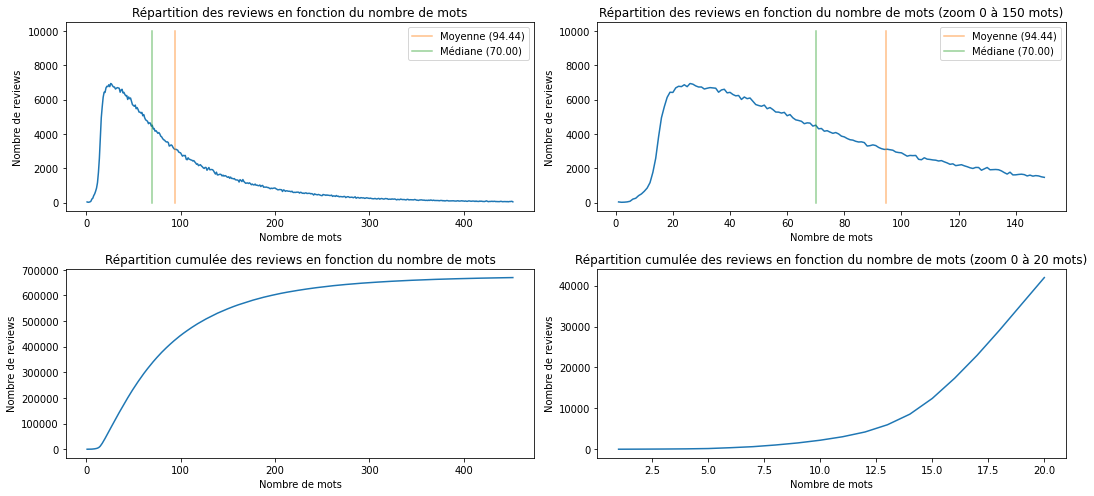

In [30]:
data_tmp = data_clean.copy()
data_tmp['review_size'] = data_clean.text.apply(lambda x: len(x.split()))
plot_review_sizes(data_tmp)

### Explorons un peu les textes qui n'ont √©t√© d√©coup√©s qu'en un seul "mot"

In [31]:
print(data_clean.text[ data_clean.review_size == 1 ][:20])

27539                                                   Boo
67931     ÊÑèÈ§êÔºåËê•‰∏öÂà∞Êôö‰∏ä10ÁÇπÔºåmixÁöÑÂä†Â∑ûÁ∫¢ÈÖíÂæàÂ•ΩÔºåËøôÈáåÊúâÊÑèÂ§ßÂà©ÂíåÂä†Â∑ûÁöÑËë°ËêÑÈÖíÔºåÁâõÊéíÁ®çÂæÆËøáÁÜü‰∫ÜÔºå‰∫∫...
69333                                               Awesome
142373    Â§™ÁæéÂë≥ÔºÅËøûÁª≠ÂêÉ‰∫Ü‰∏§‰∏™Êôö‰∏äÔºåÊòØÂú®ÁæéÂõΩÂ∞ëÊúâÁöÑÈ≤úÁæéÔºåËÄåÁéØÂ¢ÉÂèàÈùûÂ∏∏‰∏çÈîô„ÄÇÊò®Â§©ÁöÑÊãÖÊãÖÈù¢„ÄÅÈ¶ôËèáÈùíËèúÈÉΩÂæàÂ•Ω...
144918                                           C'mon!!!!!
183565                                                  Lll
184566                                                  Wow
259830    ÊãõÁâåÊ≤ôÊãâÂ∞±ÊòØÁîüËèúÂè∂ÊãåÂí∏Âë≥Ê≤ôÊãâÈÖ±ÔºåÊòüÊúüÂõõÁâπ‰æõÁöÑÁÇíÈ•≠Â∞±ÊòØÂâ©È•≠ÁÇíÈ•≠ÔºåÁªøÊ¥ãËë±È¶ôËÇ†ÁöÑÂë≥ÈÅìÂÆûÂú®‰∏çÊï¢ÊÅ≠Áª¥Ôºå...
265618                                                    .
267429    „ÉÄ„Ç¶„É≥„Çø„Ç¶„É≥„ÅÆÂ§ñ„Çå„Å´„ÅÇ„ÇãÈùô„Åã„Å™„É¨„Çπ„Éà„É©„É≥„ÄÇ„Éá„Ç£„Éä„Éº„ÇíÈ£ü„Åπ„Å´Ë°å„Å£„Åü„Åå„ÄÅ„Ç™„Ç∑„É£„É¨„Å™Á©∫Èñì„ÅÆÂâ≤„Å´Èùô„Åã...
352724                                    

>#### On constate que:
> - il y a de nombreux textes qui ne sont pas en Anglais...
> - il y a des url seules
> - il y a des smileys seuls
> - il y a des mots seuls

---
>#### `TODO`  done ‚úÖ | todo ‚ùå |
> - ‚úÖ Il faut faire en sorte de ne garder que les textes en Anglais.
<br><u>*(action: fait juste apr√®s la tokenization)*</u>
> - ‚ùå Il faut supprimer les entr√©es avec des URL seules.
> - ‚úÖ Il faut supprimer les reviews d'un seul mot *(elles ne sont que 48 sur 1 millions si l'on compte les langues asiatiques mal splitt√©es)*.
<br><u>*(action: fait ci-dessous)*</u>

#### Supprimons les outliers avec trop peu de textes

In [32]:
data_clean = data_clean[ data_clean.review_size > 1 ][['stars','text']]
display(data_clean.head(2), data_clean.shape)

stars                                               text
0      3  If you decide to eat here, just be aware it is...
2      3  Family diner. Had the buffet. Eclectic assortm...

(669575, 2)

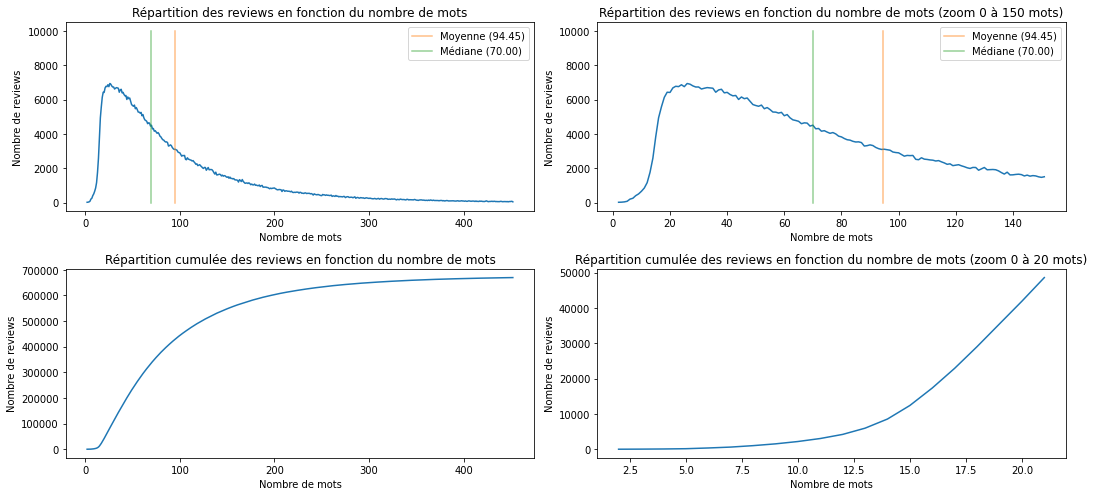

In [33]:
data_tmp = data_clean.copy()
data_tmp['review_size'] = data_clean.text.apply(lambda x: len(x.split()))
plot_review_sizes(data_tmp)

### R√©partition des notes *(stars)* des reviews

In [34]:
def plot_bars(data_, title, labels_modulo=1, labels_rotation=90, show_values=True, show_percent=False, x_label=None, y_label=None, **args):
    
    if show_percent:
        total = data_.values.sum()
        data_ = round(data_/total*100.0,2)
        
    fig = plt.figure(figsize=(15, 4))
        
    #with plt.rc_context({
    #    'axes.edgecolor':'orange',
    #    'xtick.color':'orange', 
    #    'ytick.color':'orange', 
    #    'text.color': 'orange',
    #    'axes.labelcolor': 'orange',
        #'figure.facecolor':'orange'
    #}):

    ax = sns.barplot(data=data_, **args)

    if show_values:
        ax.bar_label(ax.containers[0])

    new_ticks = [i.get_text() for i in ax.get_xticklabels()]
    plt.xticks(range(0, len(new_ticks), labels_modulo), new_ticks[::labels_modulo], rotation=labels_rotation)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

    #fig.savefig(f"medias/export.png", transparent=True)

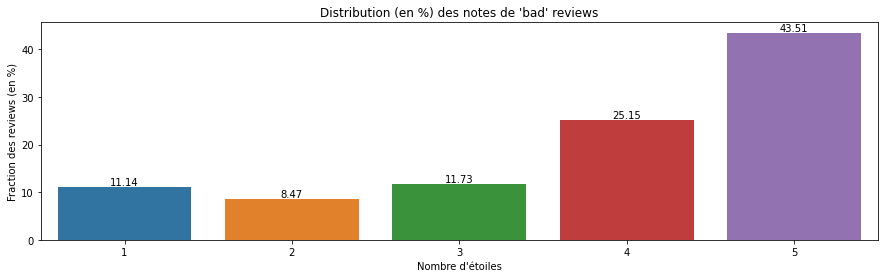

In [35]:
select = pd.DataFrame(data_clean.stars.value_counts()).reset_index()
select.sort_values(by='index', inplace=True)
select.set_index('index', inplace=True)

plot_bars(select.T, "Distribution (en %) des notes de 'bad' reviews", y_label="Fraction des reviews (en %)", x_label="Nombre d'√©toiles", labels_rotation=0, show_percent=True)

>#### Nous constatons que la majorit√© des clients semblent satisfaits.
> Mais dans le cadre de notre projets nous voulons surtout identifier *les sujets qui pr√©occupent les personnes ayant laiss√© une mauvaise note*.<br>
> Nous allons donc travailler sur un √©chantillon de reviews dont les notes sont de 1 ou 2.

#### Binarisation du jeu de donn√©es

In [36]:
data_clean['is_low'] = data_clean.stars <= 2 # TRUE with 1,2 stars and FALSE with 3,4,5 stars
display(data_clean.head(2), data_clean.shape)

stars                                               text  is_low
0      3  If you decide to eat here, just be aware it is...   False
2      3  Family diner. Had the buffet. Eclectic assortm...   False

(669575, 3)

In [37]:
data_clean[data_clean.is_low].shape

(131323, 3)

>#### On a donc environ 216k "mauvaises" reviews √† utiliser *(en ayant limit√© le nombre initial de reviews charg√©es √† 1000k)*

#### S√©lection au hasard des "mauvaises" reviews *(en conservant le ratio initial des notes)*

In [38]:
sample_size = 10000

In [39]:
# Select samples with the original dataset stars' ratio
data_bad_reviews = data_clean[data_clean.is_low == True].sample(sample_size, random_state=random_seed)[['stars', 'text']].reset_index(drop=True)
display(data_bad_reviews.head(2), data_bad_reviews.shape)

stars                                               text
0      2  Went on a Saturday afternoon for lunch with a ...
1      2  We tried this place twice. Seating was slow, s...

(10000, 2)

#### Affichage de la distribution des scores dans le nouveau dataset

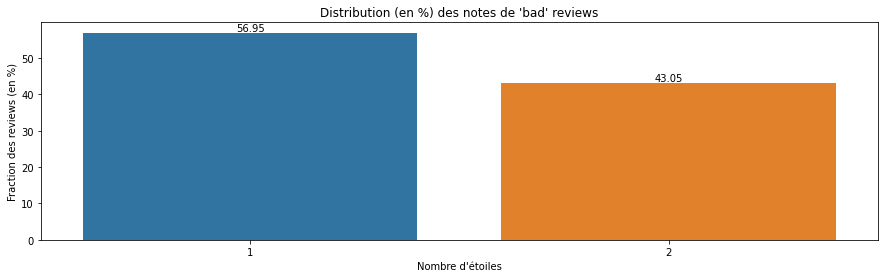

In [40]:
select = pd.DataFrame(data_bad_reviews.stars.value_counts()).reset_index()
select.sort_values(by='index', inplace=True)
select.set_index('index', inplace=True)

plot_bars(select.T, "Distribution (en %) des notes de 'bad' reviews", y_label="Fraction des reviews (en %)", x_label="Nombre d'√©toiles", labels_rotation=0, show_percent=True)

---
---
# 3. Pr√©traitement des donn√©es <a class="anchor" id="pretraitement"></a> [‚á™](#menu)

Nous allons utiliser pour pr√©parer les donn√©es √† l'analyse, une biblioth√®que open-source appel√©e [spaCy](http://spacy.io), mais d'autres biblioth√®ques telles que [NLTK](https://www.nltk.org) peuvent √©galement √™tre utilis√©es.

Au cours du processus de Tokenisation, *spaCy* va ajouter plusieurs informations au document, que nous pourrons utiliser ult√©rieurement *(comme le type, le lemme, etc.)*

<img src="medias/tokenize.png" width="500">

#### Visualisons le jeu de donn√©es avant la tokenisation

In [41]:
from wordcloud import WordCloud

In [42]:
from PIL import Image

In [43]:
def plot_wordcloud(text, from_frequency=False, name="wordcloud"):
    alice_mask = np.array(Image.open("medias/plate_shape.jpg"))
    
    # Create the wordcloud object (the size depends on the mask...)
    wordcloud_export = WordCloud(background_color=None, mode="RGBA", width=1000, height=700, margin=2, collocations=False, random_state=random_seed, mask=alice_mask)
    wordcloud_clean = WordCloud(background_color="White", mode="RGB", width=1000, height=700, margin=2, collocations=False, random_state=random_seed, mask=alice_mask)
    
    if from_frequency:
        wordcloud_export = wordcloud_export.generate_from_frequencies(text)
        wordcloud_clean = wordcloud_clean.generate_from_frequencies(text)
    else:
        wordcloud_export = wordcloud_export.generate(text)
        wordcloud_clean = wordcloud_clean.generate(text)

    # Display the generated image:
    fig = plt.figure(figsize=(15, 10.5))
    plt.imshow(wordcloud_clean, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()
    
    # Export
    wordcloud_export.to_file(f"medias/{name}.png")
    
    #fig.savefig(f"medias/{name}.png", transparent=True)

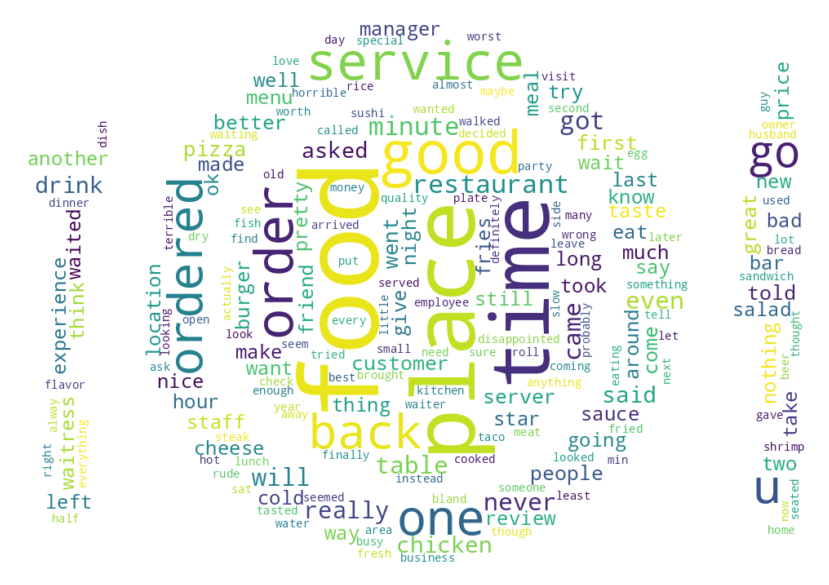

In [44]:
plot_wordcloud(" ".join([x for x in data_bad_reviews.text]), name="wordcloud1")

## 3.1 Tokenization <a class="anchor" id="tokenize"></a> [‚á™](#menu)
>#### Nous allons profiter de cette √©tape de tokenisation pour supprimer:
> - les majuscules,
> - les espaces en d√©but et fin de texte.

In [45]:
!python -m spacy download en_core_web_sm -qq
#!python -m spacy download en_core_web_md -qq
nlp = spacy.load('en_core_web_sm')

2022-07-11 17:07:08.129130: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-11 17:07:08.129165: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
‚úî Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [46]:
nlp.add_pipe("language_detector")

In [47]:
def tokenize(text):

    # suppression des majuscules
    text = text.lower()

    # suppression des espaces au d√©but et √† la fin des textes
    text = text.strip()

    # tokenisation
    return nlp(text)

In [48]:
display(data_bad_reviews.head(2), data_bad_reviews.shape)

stars                                               text
0      2  Went on a Saturday afternoon for lunch with a ...
1      2  We tried this place twice. Seating was slow, s...

(10000, 2)

### Pr√©parons les Tokens *(ou chargeons les si ils ont d√©j√† √©t√© sauvegard√©s)*

In [49]:
def save_tokens(data, path):
    #doc_bin = DocBin(attrs=["LEMMA", "ENT_IOB", "ENT_TYPE"], store_user_data=True)
    doc_bin = DocBin(store_user_data=True)
    data.apply(lambda x: doc_bin.add(x))
    bytes_data = doc_bin.to_bytes()
    
    with open(path, "wb") as binary_file:
        binary_file.write(bytes_data)
        
def load_tokens(path):
    with open(path, "rb") as binary_file:
        bytes_data = binary_file.read()
        
    nlp = spacy.blank("en")
    doc_bin = DocBin().from_bytes(bytes_data)
    docs = list(doc_bin.get_docs(nlp.vocab))
    
    return docs

In [50]:
if(os.path.exists(TOKENS_PATH) and LOAD_TOKENS_FROM_FILE==True):
    print(f"LOADING Tokens from '{TOKENS_PATH}'")
    data_bad_reviews['spacy_doc'] = load_tokens(TOKENS_PATH)
else:
    print(f"PREPARING Tokens")
    data_bad_reviews['spacy_doc'] = data_bad_reviews.text.apply(tokenize)
    print(f"SAVING Tokens tp '{TOKENS_PATH}'")
    save_tokens(data_bad_reviews['spacy_doc'], TOKENS_PATH)

LOADING Tokens from 'data/tokens.bin'


In [51]:
display(data_bad_reviews.head(2), data_bad_reviews.shape)

stars                                               text  \
0      2  Went on a Saturday afternoon for lunch with a ...   
1      2  We tried this place twice. Seating was slow, s...   

                                           spacy_doc  
0  (went, on, a, saturday, afternoon, for, lunch,...  
1  (we, tried, this, place, twice, ., seating, wa...

(10000, 3)

## 3.2 Filtrage des tokens <a class="anchor" id="filter"></a> [‚á™](#menu)

>#### Nous allons profiter de cette √©tape pour supprimer:
> - ~~les majuscules~~ *(fait lors de la tokenization)*,
> - ~~les espaces en d√©but et fin de texte.~~ *(fait lors de la tokenization)*,
> - tout ce qui n'est pas d√©tect√© comme √©tant de l'anglais *(language & language_score)*,
> - la ponctuation *(PUNCT)*,
> - les stop-words *(is_stop)*,
> - les espaces *(SPACE)*,
> - les chiffres *(is_alpha)*,
> - mais aussi les beaucoup d'autres tags peu utiles dans ce cas *(ADV, AUX, CONJ, CCONJ, DET, PART, PRON, PROPN, SCONJ, SYM)*.
>
>#### Par ailleurs on va utiliser les **lemmes** *(ra√ßines contextualis√©es)* des mots pour rassembler ceux qui sont assez similaires.

> pos_ tag ist
>
> - `ADJ`: adjective, e.g. big, old, green, incomprehensible, first
> - `ADP`: adposition, e.g. in, to, during
> - `ADV`: adverb, e.g. very, tomorrow, down, where, there
> - `AUX`: auxiliary, e.g. is, has (done), will (do), should (do)
> - `CONJ`: conjunction, e.g. and, or, but
> - `CCONJ`: coordinating conjunction, e.g. and, or, but
> - `DET`: determiner, e.g. a, an, the
> - `INTJ`: interjection, e.g. psst, ouch, bravo, hello
> - `NOUN`: noun, e.g. girl, cat, tree, air, beauty
> - `NUM`: numeral, e.g. 1, 2017, one, seventy-seven, IV, MMXIV
> - `PART`: particle, e.g. ‚Äôs, not,
> - `PRON`: pronoun, e.g I, you, he, she, myself, themselves, somebody
> - `PROPN`: proper noun, e.g. Mary, John, London, NATO, HBO
> - `PUNCT`: punctuation, e.g. ., (, ), ?
> - `SCONJ`: subordinating conjunction, e.g. if, while, that
> - `SYM`: symbol, e.g. $, %, ¬ß, ¬©, +, ‚àí, √ó, √∑, =, :), üòù
> - `VERB`: verb, e.g. run, runs, running, eat, ate, eating
> - `X`: other, e.g. sfpksdpsxmsa
> - `SPACE`: space, e.g. 

In [52]:
def filter_tokens(doc, except_words = []):

    # suppression des majuscules
    # text = text_.lower()

    # suppression des espaces au d√©but et √† la fin des textes
    #text = text.strip()

    # tokenisation
    # doc = nlp(text)
    # spacy.displacy.render(doc, style='dep',jupyter=True)
    
    # suppression des stopwords, de la ponctuation, des espaces et des adverbes et de ce qui n'est pas en anglais
    tokens = [token for token in doc 
              if not token.is_stop 
              and doc._.language == 'en'
              and doc._.language_score > 0.7
              #and not token.is_punct
              #and not token.is_space 
              #and not token.is_digit 
              and token.is_alpha
              and token.pos_ not in ['ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SPACE', 'SYM'] 
              and token.lemma_ not in except_words
             ]
        
    return tokens if len(tokens) > 1 else "FILTERED"

#### Regardons si il y a des textes dans d'autres langues ou dans de l'anglais approximatif ou argotique

In [53]:
for doc in data_bad_reviews.spacy_doc:
    # is in english
    if doc._.language != 'en':
        print("NOT ENGLISH:\n", doc, "\n", "-"*50)
    elif doc._.language_score <= 0.7:
        print(f"GIBBERISH:{doc._.language_score}\n", doc, "\n", "-"*50)

GIBBERISH:0.4564344882965088
 good grilled chicken sandwich.  bland fries. 
 --------------------------------------------------
NOT ENGLISH:
 ÂÄ§ÊÆµ„ÇÇÈ´ò„Åè„ÄÅ„ÅäÂë≥„ÇÇÊôÆÈÄö„ÄÇË¶≥ÂÖâÂÆ¢Âêë„Åë„ÅÆ„Ç∑„Éº„Éï„Éº„Éâ„É¨„Çπ„Éà„É©„É≥„ÄÇ„ÄÇ„ÉØ„Ç§„É≥„Ç∞„É©„Çπ„ÅßÊèê‰æõ„Åï„Çå„Å™„ÅÑ„ÉØ„Ç§„É≥„ÇíÂàù„ÇÅ„Å¶„Åø„Åæ„Åó„Åü„ÄÇ
Â∫óÂÜÖ„ÅØ„Ç´„Ç¶„É≥„Çø„ÉºÂ∏≠„Åó„Åã„ÅÇ„Çä„Åæ„Åõ„Çì„Åß„Åó„Åü„ÄÇÊ∞óÂÄô„ÅåËâØ„Åë„Çå„Å∞Â§ñ„ÅÆ„ÉÜ„Éº„Éñ„É´„ÅÆÊñπ„ÅåÊ∞óÊåÅ„Å°ËâØ„Åï„Åù„ÅÜ„Åß„Åô„ÄÇ 
 --------------------------------------------------
NOT ENGLISH:
 no es buena, la pizza es tarta de culo y huele a tripa de pescado 
 --------------------------------------------------
NOT ENGLISH:
 fui con unos amigos a este lugar s√∫per recomendado y nuestra experiencia fue p√©sima. lo que vas a ver en el men√∫ son todo tapas a precios de platos principales.  ojo ok son platicos m√≠nimos para picar. un amigo le llego primero su plato y a los 15 min llego el resto. el servicio mediocre. pero lo peor la m√∫sica una tipa con voz que solo me agrada

>#### On d√©couvre:
> - plusieurs textes en espagnol ou en japonais/chinois
> - un casier judiciaire
> - des textes r√©dig√©s en plusieurs langues

---
>#### `TODO`  done ‚úÖ | todo ‚ùå |
> - ‚úÖ Suppression des langues √©trang√®res *(ce qui n'est pas de l'Anglais)*
<br><u>*(action: fait ci-dessous avec la function filter_tokens)*</u>
> - ‚úÖ Suppression des stop-words
<br><u>*(action: fait ci-dessous avec la function filter_tokens)*</u>
> - ‚úÖ Suppression des mots qui ne sont pas compos√©s de lettres de l'alphabet
<br><u>*(action: fait ci-dessous avec la function filter_tokens)*</u>

In [54]:
data_bad_reviews['tokens'] = data_bad_reviews.spacy_doc.apply(filter_tokens)

## 3.3 Lemmatization des tokens <a class="anchor" id="lemmatize"></a> [‚á™](#menu)

In [55]:
def lemmatize(doc):
    return [token.lemma_ for token in doc if type(token) != str]

#### Lemmatisons les tokens

In [56]:
data_bad_reviews['lemmas'] = data_bad_reviews.tokens.apply(lemmatize)
display(data_bad_reviews.head(2), data_bad_reviews.shape)

stars                                               text  \
0      2  Went on a Saturday afternoon for lunch with a ...   
1      2  We tried this place twice. Seating was slow, s...   

                                           spacy_doc  \
0  (went, on, a, saturday, afternoon, for, lunch,...   
1  (we, tried, this, place, twice, ., seating, wa...   

                                              tokens  \
0  [went, afternoon, lunch, party, seated, menu, ...   
1  [tried, place, seating, slow, service, slow, f...   

                                              lemmas  
0  [go, afternoon, lunch, party, seat, menu, look...  
1  [try, place, seating, slow, service, slow, foo...

(10000, 5)

#### Regardons si ils ont tous des lemmes...

In [57]:
data_bad_reviews[data_bad_reviews['lemmas'].str.len() == 0].shape

(7, 5)

In [58]:
data_bad_reviews[data_bad_reviews['lemmas'].str.len() == 0]

stars                                               text  \
809       2       Good grilled chicken sandwich.  Bland fries.   
2834      2  ÂÄ§ÊÆµ„ÇÇÈ´ò„Åè„ÄÅ„ÅäÂë≥„ÇÇÊôÆÈÄö„ÄÇË¶≥ÂÖâÂÆ¢Âêë„Åë„ÅÆ„Ç∑„Éº„Éï„Éº„Éâ„É¨„Çπ„Éà„É©„É≥„ÄÇ„ÄÇ„ÉØ„Ç§„É≥„Ç∞„É©„Çπ„ÅßÊèê‰æõ„Åï„Çå„Å™„ÅÑ„ÉØ„Ç§„É≥...   
3308      1  no es buena, la pizza es tarta de culo y huele...   
5287      1  Fui con unos amigos a este lugar s√∫per recomen...   
6839      2  Third and most likely last visit.  Overpriced,...   
8489      2  Ekta ALL the way.  Sorry Tiffin. 2 stars for t...   
8978      1  Muy costoso, mala calidad, no es posible que u...   

                                              spacy_doc    tokens lemmas  
809   (good, grilled, chicken, sandwich, .,  , bland...  FILTERED     []  
2834  (ÂÄ§ÊÆµ„ÇÇÈ´ò„Åè„ÄÅ„ÅäÂë≥„ÇÇÊôÆÈÄö„ÄÇË¶≥ÂÖâÂÆ¢Âêë„Åë„ÅÆ„Ç∑„Éº„Éï„Éº„Éâ„É¨„Çπ„Éà„É©„É≥„ÄÇ„ÄÇ„ÉØ„Ç§„É≥„Ç∞„É©„Çπ„ÅßÊèê‰æõ„Åï„Çå„Å™„ÅÑ„ÉØ„Ç§...  FILTERED     []  
3308  (no, es, buena, ,, la, pizza, es, tarta, de, c...  FILTERED     []  
5287  (fui, con, unos, amigos, a, este, lugar, s√∫per...  FILTERED     []  
6839  (third, and, most, likely, last, visit, .,  , ...  FILTERED     []  
8489  (ekta, all, the, way, .,  , sorry, tiffin, ., ...  FILTERED     []  
8978  (muy, costoso, ,, mala, calidad, ,, no, es, po...  FILTERED     []

#### Supprimons ces quelques phrases *(√ßa √©vitera des probl√®mes plus tard avec les mesures de coh√©rence c_v par exemple)* 

In [59]:
data_bad_reviews = data_bad_reviews[data_bad_reviews.tokens != 'FILTERED']
display(data_bad_reviews.head(2), data_bad_reviews.shape)

stars                                               text  \
0      2  Went on a Saturday afternoon for lunch with a ...   
1      2  We tried this place twice. Seating was slow, s...   

                                           spacy_doc  \
0  (went, on, a, saturday, afternoon, for, lunch,...   
1  (we, tried, this, place, twice, ., seating, wa...   

                                              tokens  \
0  [went, afternoon, lunch, party, seated, menu, ...   
1  [tried, place, seating, slow, service, slow, f...   

                                              lemmas  
0  [go, afternoon, lunch, party, seat, menu, look...  
1  [try, place, seating, slow, service, slow, foo...

(9993, 5)

#### Visualisons le jeu de donn√©es apr√®s la tokenisation

In [60]:
def get_all_lemmas(data):
    all_lemmas = []
    for tokens in data:
        all_lemmas.extend(tokens)
    return all_lemmas

all_lemmas = get_all_lemmas(data_bad_reviews.lemmas)

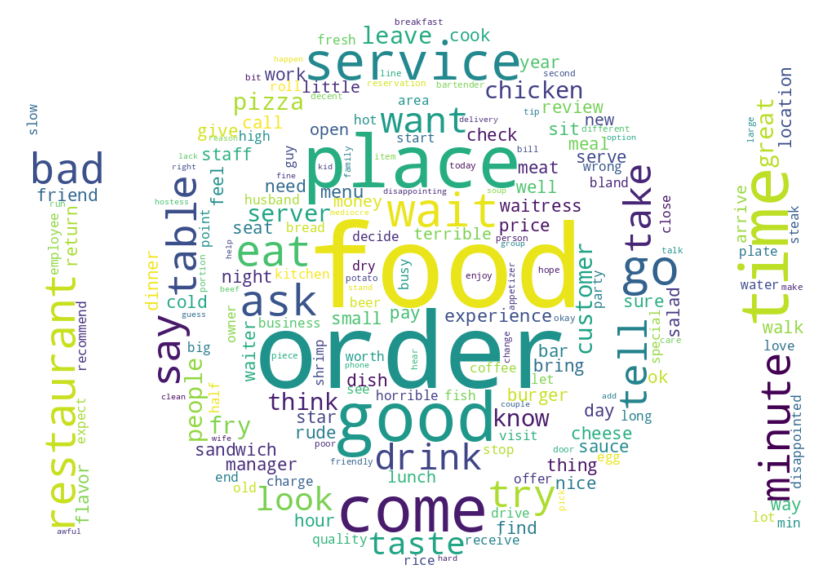

In [61]:
plot_wordcloud(" ".join(all_lemmas), name="wordcloud2")

## 3.4 Suppression des mots les plus fr√©quents <a class="anchor" id="most_frequents"></a> [‚á™](#menu)

In [62]:
lemmas_freq = Counter(all_lemmas)
common_lemmas = lemmas_freq.most_common(100)
print (common_lemmas)

[('food', 8900), ('order', 7998), ('place', 5657), ('good', 4886), ('time', 4756), ('come', 4520), ('service', 4202), ('go', 3672), ('wait', 3263), ('like', 3255), ('get', 3200), ('ask', 2861), ('restaurant', 2817), ('eat', 2739), ('minute', 2661), ('bad', 2620), ('say', 2533), ('table', 2501), ('tell', 2326), ('try', 2214), ('take', 2151), ('want', 2093), ('drink', 2016), ('taste', 1972), ('look', 1927), ('chicken', 1820), ('leave', 1768), ('know', 1754), ('pizza', 1741), ('great', 1705), ('people', 1649), ('fry', 1637), ('customer', 1608), ('think', 1606), ('server', 1603), ('experience', 1559), ('sit', 1495), ('menu', 1457), ('meal', 1398), ('waitress', 1360), ('hour', 1343), ('staff', 1315), ('manager', 1305), ('price', 1295), ('well', 1294), ('give', 1290), ('cheese', 1282), ('serve', 1279), ('bar', 1270), ('thing', 1226), ('star', 1216), ('sauce', 1201), ('salad', 1189), ('review', 1161), ('need', 1139), ('way', 1135), ('nice', 1111), ('burger', 1107), ('walk', 1106), ('pay', 110

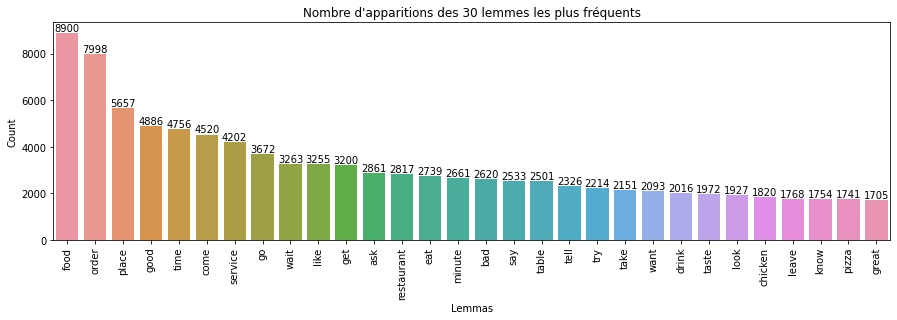

In [63]:
select = pd.DataFrame(common_lemmas[:30], columns=['lemmas','count'])
plot_bars(select, title="Nombre d'apparitions des 30 lemmes les plus fr√©quents", x='lemmas', y='count', show_values=True, y_label="Count", x_label="Lemmas")

>#### Les mots les plus fr√©quents sont des mots peu informatifs car pr√©sent dans la plupart des textes...
> Par exemple les lemmes `Food` ou `order` font plus de 6000 aparitions sur un jeu de donn√©es d'environ 10000 textes.

In [64]:
drop_lemmas = [x[0] for x in lemmas_freq.most_common(100)]
#drop_lemmas.extend(['come', 'go', 'tell', 'say', 'get', 'ask', 'want', 'try', 'look', 'take', 'find', 'let', 'guy', 'arrive', 'think'])

#### Visualisons le jeu de donn√©es apr√®s ce nettoyage plus complet

---
>#### `TODO`  done ‚úÖ | todo ‚ùå |
> - ‚úÖ Suppression les lemmes les plus fr√©quents
<br><u>*(action: fait avec la fonction `filter_extremes` du Dictionnaire un peu plus bas, au lieu du code ci-dessus)*</u>
> - ‚úÖ Suppression des lemmes les moins fr√©quents
<br><u>*(action: fait avec la fonction `filter_extremes` du Dictionnaire un peu plus bas, au lieu du code ci-dessus)*</u>

## 3.5 Cr√©ation du Dictionnaire <a class="anchor" id="dict"></a> [‚á™](#menu)

Pour les mod√®les que nous allons essayer, il nous faut un **Dictionnaire** et un **Corpus**.
- Le Dictionnaire permet d'associer un ID unique √† chaque token.
- Le `Corpus - Bag Of Word` contient une liste (un pour chaque document) de *term vectors* qui indiquent la fr√©quence de chaque mot du *vocabulaire*.
- Le `Corpus - TF-IDF` est une version *normalis√©e* du pr√©c√©dent pour √©viter que des mots sans importance mais fr√©quents prennent trop d'importance.

In [65]:
from gensim.corpora.dictionary import Dictionary

In [66]:
dictionary = Dictionary(data_bad_reviews['lemmas'])

In [67]:
print(str(dictionary.token2id)[:1000], "... }")

{'afternoon': 0, 'app': 1, 'bill': 2, 'burger': 3, 'cig': 4, 'come': 5, 'cost': 6, 'counter': 7, 'delay': 8, 'delicious': 9, 'disappointed': 10, 'discount': 11, 'drink': 12, 'eat': 13, 'effective': 14, 'etc': 15, 'food': 16, 'frame': 17, 'fry': 18, 'go': 19, 'good': 20, 'hold': 21, 'hour': 22, 'look': 23, 'lunch': 24, 'manager': 25, 'mean': 26, 'medium': 27, 'menu': 28, 'minute': 29, 'multiple': 30, 'nice': 31, 'one': 32, 'option': 33, 'order': 34, 'pack': 35, 'party': 36, 'patient': 37, 'pickle': 38, 'plenty': 39, 'point': 40, 'rare': 41, 'reasonable': 42, 'return': 43, 'right': 44, 'ring': 45, 'round': 46, 'salad': 47, 'seat': 48, 'shack': 49, 'shake': 50, 'side': 51, 'slaw': 52, 'smell': 53, 'smoke': 54, 'standard': 55, 'start': 56, 'starve': 57, 'suppose': 58, 'take': 59, 'tell': 60, 'time': 61, 'vary': 62, 'wait': 63, 'waiter': 64, 'weird': 65, 'wonder': 66, 'yummy': 67, 'cold': 68, 'place': 69, 'seating': 70, 'service': 71, 'slow': 72, 'try': 73, 'ask': 74, 'clientele': 75, 'disa

In [68]:
len(dictionary)

13696

#### Supprimons les mots les plus fr√©quents et les moins fr√©quents
- On supprime les mots qui apparaissent dans moins de 5 documents
- On supprime les mots qui apparaissent dans plus de 50% des documents

In [69]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=None)

In [70]:
len(dictionary)

4258

#### R√©cup√©rons la Fr√©quence de chaque lemme pour afficher √† nouveau le WordCloud

In [71]:
dico_df = pd.DataFrame(dictionary.items(), columns=['index', 'key']).set_index('index')

In [72]:
values = [[x[0], x[1]] for x in dictionary.cfs.items()]

In [73]:
count_df = pd.DataFrame(values, columns=['index','count']).set_index('index').sort_values('index')

In [74]:
TF = count_df.merge(dico_df, on='index', how='left').set_index('key')

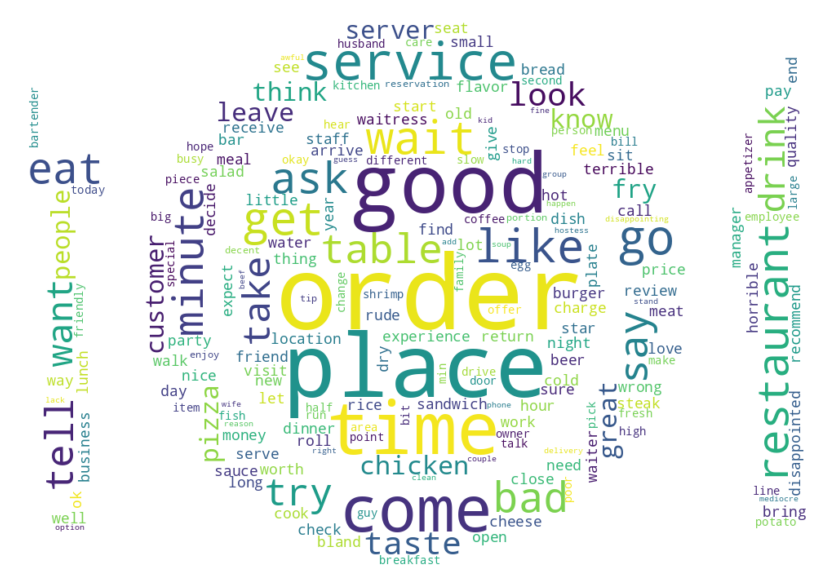

In [75]:
plot_wordcloud(TF.to_dict()['count'], from_frequency=True, name="wordcloud3")

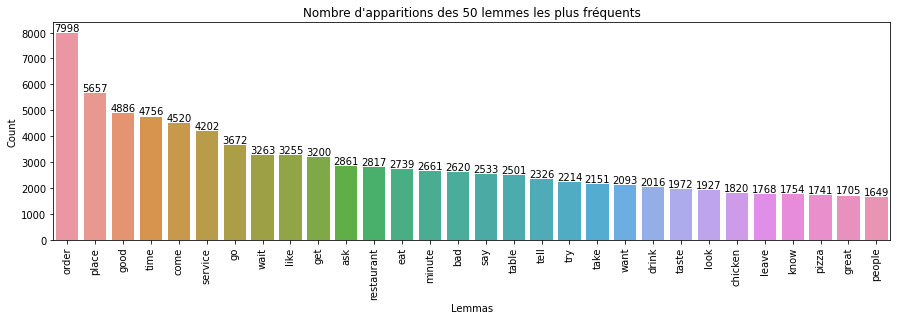

In [76]:
plot_bars(TF.sort_values('count', ascending=False)[:30].T, title="Nombre d'apparitions des 50 lemmes les plus fr√©quents", show_values=True, y_label="Count", x_label="Lemmas")

## 3.6 Cr√©ation du Corpus Bag-Of-Words <a class="anchor" id="corpus_bow"></a> [‚á™](#menu)

Le `Corpus - Bag Of Word` contient une liste (un pour chaque document) de *term vectors* qui indiquent la fr√©quence de chaque mot du *vocabulaire*.

In [77]:
corpus_bow = [dictionary.doc2bow(doc) for doc in data_bad_reviews['lemmas']]

## 3.7 Cr√©ation du Corpus TF-IDF <a class="anchor" id="corpus_tfidf"></a> [‚á™](#menu)
Le `Corpus - TF-IDF` est une version *normalis√©e* du Bag-Of-Words pour √©viter que des mots sans importance mais fr√©quents prennent trop d'importance.

In [78]:
from gensim.models import TfidfModel

In [79]:
tfidf = TfidfModel(corpus_bow) # on a pas besoin de mettre les min_df et max_df ici car on a d√©j√† appliqu√© un filter_extremes sur le Dictionnary
corpus_tfidf = tfidf[corpus_bow]

## 3.8 Cr√©ation d'un Corpus Word2Vec <a class="anchor" id="corpus_word2vec"></a> [‚á™](#menu)
Le `Corpus - Word2vec` associe un vecteur √† chaque mot du *vocabulaire* au lieu d'une valeur de fr√©quence (normalis√©e ou non). Cett particularit√© permet de retrouver plus facilement des mots similaires *( Homme --> Chercheur | Femme --> ? --> Chercheuse)*

> ‚ö†Ô∏è Finalement je ne l'ai pas utilis√©, donc je desactive les lignes de code ci-dessous

In [80]:
from gensim.models import Word2Vec

In [81]:
w2v_model = Word2Vec(data_bad_reviews['lemmas'], vector_size=500, min_count=5, sg=1)

---
---
# 4. Topic Modelling avec LDA<a class="anchor" id="lda_topic_modelling"></a> [‚á™](#menu)

## 4.1 Latent Dirichlet Allocation *(LDA)* <a class="anchor" id="lda"></a> [‚á™](#menu)

C'est une m√©thode non-supervis√©e g√©n√©rative vraiment efficace qui se base sur les hypoth√®ses suivantes :
- Chaque document du corpus est un ensemble de mots sans ordre (bag-of-words)
- Chaque document *m* aborde un certain nombre de th√®mes dans diff√©rentes proportions qui lui sont propres *p(Œ∏m)*
- Chaque mot poss√®de une distribution associ√©e √† chaque th√®me *p(œïk)*. On peut ainsi repr√©senter chaque th√®me par une probabilit√© sur chaque mot.
- *z_n* repr√©sente le th√®me du mot *w_n*

> ‚ö†Ô∏è "In fact, Blei (who developed LDA), points out in the introduction of the paper of 2003 (entitled "Latent Dirichlet Allocation") that LDA addresses the shortcomings of the TF-IDF model and leaves this approach behind. LSA is compeltely algebraic and generally (but not necessarily) uses a TF-IDF matrix, while LDA is a probabilistic model that tries to estimate probability distributions for topics in documents and words in topics. The weighting of TF-IDF is not necessary for this."
>
> ‚ö†Ô∏è Le mod√®le **TF-IDF peut am√©liorer les r√©sultats d'un LDA** dans le cas d'un **nombre extr√™mement important de documents**. Mais dans l'ensemble, le **Bag-Of-Words est plus appropri√©** pour le mod√®le LDA.

#### Regardons ce qui donne un mod√®le LDA sur 10 topics

In [82]:
from gensim.models import LdaMulticore, CoherenceModel

In [83]:
lda_model = LdaMulticore(corpus=corpus_bow, id2word=dictionary, iterations=50, num_topics=10, passes=10, random_state=random_seed)

In [84]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus_bow, dictionary)
pyLDAvis.display(lda_display)

>#### On voit assez clairement que le nombre de cluster n'est pas id√©al... ils sont tr√®s proches les uns des autres, ils se chevauchent.

## 4.2 Recheche du nombre optimal de sujets <a class="anchor" id="lda_coherence"></a> [‚á™](#menu)

Les algorithmes de topic modelling reposent sur les math√©matiques et les statistiques, mais les sujets math√©matiquement optimaux ne sont pas n√©cessairement "bons" d'un point de vue humain et peuvent √™tre des sujets trompeurs et d√©nu√©s de sens.

L'√©valuation des sujets est donc habituellement compl√©t√©e par des √©valuations humaines telles que la lecture des mots les plus importants de chaque sujet et la visualisation des sujets li√©s √† chaque document *(word-cloud utilis√©s plus haut)*. Malheureusement, cette t√¢che exige souvent des connaissances pr√©alables sur le domaine du jeu de donn√©es et peut n√©cessiter l'avis de sp√©cialistes. Et m√™me si l'on dispose d'un tel sp√©cialiste, une telle v√©rification peut prendre beaucoup de temps et s'av√©rer impraticable pour de tr√®s grands ensembles de donn√©es contenant des milliers de sujets.

#### Score de Coh√©rence

Il convient donc d'utiliser une m√©trique capable de v√©rifier **automatiquement** que les mots group√©s ensemble ont bel et bien un th√®me commun. C'est ce que font les m√©triques de **mesure de coh√©rence** des sujets qui tentent de repr√©senter la qualit√© de la perception humaine des sujets sous la forme d'un nombre unique en mesurant le degr√© de similarit√© s√©mantique entre les mots ayant obtenu un score √©lev√© dans chaque th√®me *(c.a.d. la distance relative entre les mots d'un m√™me sujet)*.

Un point important des mesures de coh√©rence des sujets est qu'**elles d√©pendent non seulement du sujet lui-m√™me mais aussi de l'ensemble de donn√©es utilis√© comme r√©f√©rence**...

<img src="medias/coherence_score.png" width="400">

Il existe plusieurs mod√®les pour calculer un score de co√©herence *(C_v, C_p, C_uci, C_umass, C_npmi, C_a, ...)*, mais nous allons utiliser le mod√®le C_umass car il est souvent recommand√© *(mais aussi parcque c'est celui qui m'a donn√© les r√©sultats les plus rapides lors de mes tests...)*.

#### C_umass
- la mesure de coh√©rence retourn√©e par le mod√®le C_umass est n√©gative,
- plus le score est grand et plus la mesure de coh√©rence indique que le sujet est compr√©hensible par les humains.


In [85]:
def plot_coherence(scores, max_topics, min_topics=1):
    plt.figure(figsize=(10, 4))
    plt.plot(range(min_topics,max_topics), scores)
    plt.gca().xaxis.grid(True)
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.xticks(range(min_topics,max_topics))
    plt.show()

#### ~~Calculons les courbes de coh√©rence avec le corpus TF-IDF~~
> ‚ö†Ô∏è Il est pr√©f√©rable d'utiliser le Corpus BoW pour un LDA *(car le Corpus TF-IDF associ√© au LDA augmente le poids des mots rares)*<br>
> J'ai donc d√©sactiv√© les cellules ci-dessous, mais avant d√©sactivation les r√©sultats √©taient effectivement moins performants qu'avec le Corpus Bow juste apr√®s.

#### Calculons les courbes de coh√©rence avec le corpus Bag-Of-Words

In [86]:
score = []
max_topics = 15
for i in tqdm(range(1,max_topics,1)):
    lda_model = LdaMulticore(corpus=corpus_bow, id2word=dictionary, iterations=10, num_topics=i, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=lda_model, corpus=corpus_bow, dictionary=dictionary, coherence='u_mass')
    score.append(cm.get_coherence())

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [03:52<00:00, 16.58s/it]


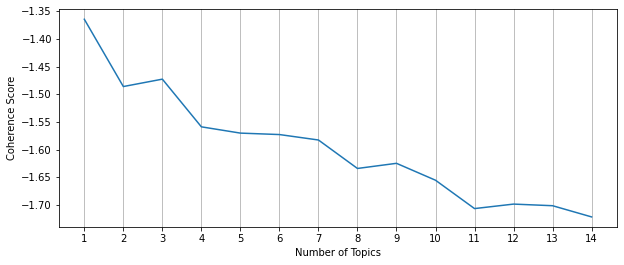

In [87]:
plot_coherence(score, max_topics)

#### Calculons le score c_v

In [88]:
score = []
max_topics = 15
for i in tqdm(range(1,max_topics,1)):
    lda_model = LdaMulticore(corpus=corpus_bow, id2word=dictionary, iterations=10, num_topics=i, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=lda_model, texts = data_bad_reviews['lemmas'], dictionary=dictionary, coherence='c_v')
    score.append(cm.get_coherence())

 29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                                                                                       | 4/14 [01:00<02:38, 15.85s/it]/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is depre

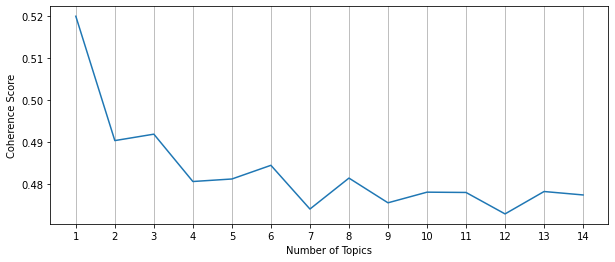

In [89]:
plot_coherence(score, max_topics)

#### Conclusion
> En regardons l'√©volution du score de coh√©rence avec le Corpus BoW (qui est plus dapt√© pour un LDA), on constate que:
> - le score de coh√©rence `c_v` comme le score `u_mass` recommandent d'utiliser **3 sujets** *(si l'on met de cot√© les 1 et 2 qui ne sont pas tr√®s utiles)*
> - le **corpus Bow** est plus adap√© que le corpus TF-IDF avec le LDA.
> - le coherence c_v score est donc **> 0.49**

---
---
# 5. Topic Modelling avec NMF<a class="anchor" id="nmf_topic_modelling"></a> [‚á™](#menu)

## 5.1 Negative Matrix Factorisation *(NMF)* <a class="anchor" id="nmf"></a> [‚á™](#menu)

C'est une m√©thode non supervis√©e, qui d√©compose *(ou factorise)* des vecteurs de haute dimension en une repr√©sentation de plus faible dimension. Ces vecteurs *(de haute dimension ou de dimension inf√©rieure)* sont non n√©gatifs, ce qui signifie √©galement que leurs coefficients sont non n√©gatifs. En utilisant la matrice originale *(A)*, la NMF donnera deux matrices *(W et H)*. 

On peut int√©rpr√©ter ces matrices comme suit:
- `A` **repr√©sente les articles par mots**,
- `W` **repr√©sente les articles par sujets** (c.a.d. les sujets trouv√©s).
- `H` **repr√©sente les sujets par mots.** (c.a.d. les coefficients des sujets trouv√©s).

In [90]:
from gensim.models import Nmf

In [91]:
import warnings
warnings.filterwarnings("ignore", message="Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.")

In [92]:
# Train the model on the corpus.
nmf = Nmf(corpus_tfidf, num_topics=10)

## 5.2 Recheche du nombre optimal de sujets <a class="anchor" id="nmf_coherence"></a> [‚á™](#menu)

#### Avec le corpus Bag-Of-Words

In [93]:
score = []
min_topics = 3
max_topics = 15
for i in tqdm(range(min_topics,max_topics,1)):
    nmf_model = Nmf(corpus=corpus_bow, num_topics=i, id2word=dictionary, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=nmf_model, corpus=corpus_bow, dictionary=dictionary, coherence='u_mass')
    score.append(cm.get_coherence())

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [01:55<00:00,  9.60s/it]


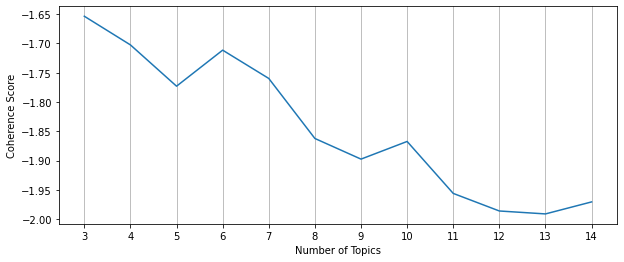

In [94]:
plot_coherence(score, max_topics, min_topics)

In [95]:
score = []
min_topics = 3
max_topics = 15
for i in tqdm(range(min_topics,max_topics,1)):
    nmf_model = Nmf(corpus=corpus_bow, num_topics=i, id2word=dictionary, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=nmf_model, texts = data_bad_reviews['lemmas'], dictionary=dictionary, coherence='c_v')
    score.append(cm.get_coherence())

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [02:23<00:00, 11.96s/it]


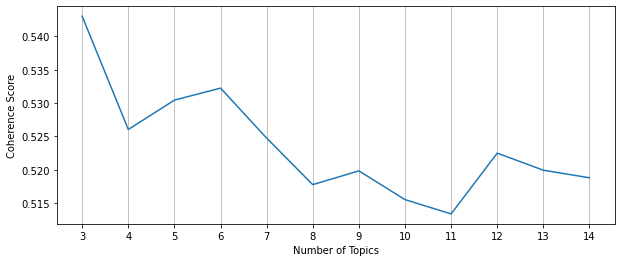

In [96]:
plot_coherence(score, max_topics, min_topics)

#### Avec le corpus TF-IDF

In [97]:
score = []
min_topics = 3
max_topics = 15
for i in tqdm(range(min_topics,max_topics,1)):
    nmf_model = Nmf(corpus=corpus_tfidf, num_topics=i, id2word=dictionary, passes=10, random_state=random_seed)
    #nmf_model = Nmf(corpus=corpus_tfidf, num_topics=i, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=nmf_model, corpus=corpus_tfidf, dictionary=dictionary, coherence='u_mass')
    score.append(cm.get_coherence())

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [05:10<00:00, 25.87s/it]


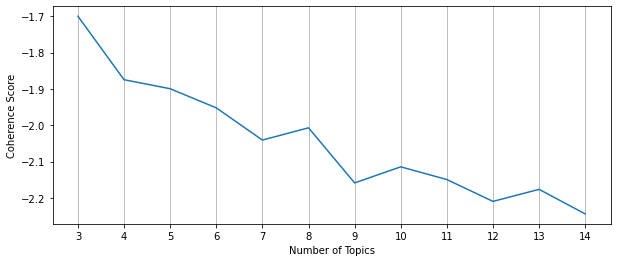

In [98]:
plot_coherence(score, max_topics, min_topics)

In [99]:
score = []
min_topics = 3
max_topics = 15
for i in tqdm(range(min_topics, max_topics,1)):
    nmf_model = Nmf(corpus=corpus_tfidf, num_topics=i, id2word=dictionary, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=nmf_model, texts = data_bad_reviews['lemmas'], dictionary=dictionary, coherence='c_v')
    score.append(cm.get_coherence())

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [05:57<00:00, 29.76s/it]


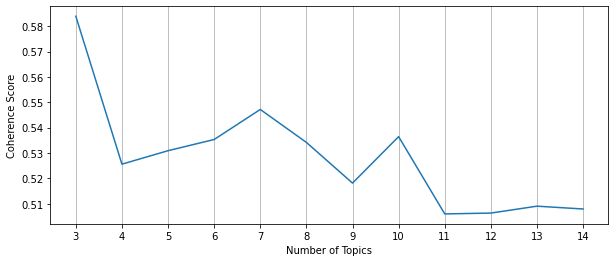

In [100]:
plot_coherence(score, max_topics, min_topics)

#### Conclusion
> En regardons l'√©volution des scores de coh√©rence avec les Corpus BoW et TF-IDF, on constate que:
> - le score de coh√©rence `c_v` qui est plus pr√©cis que le score `u_mass` recommande d'utiliser **6 ou 7 sujets**.
> - le **corpus TF-IDF** semble √™tre celui qui fonctionne le mieux sur ce jeu de donn√©es avec le NMF
> - le coherence score est donc **> 0.55**

#### (bonus) Essayons d'obtenir la m√™me chose avec sklearn

In [101]:
from sklearn.decomposition import NMF
from itertools import combinations

In [102]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [103]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [104]:
all_xxx = [" ".join(x) for x in data_bad_reviews.lemmas]
len(all_xxx)

9993

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [106]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, min_df=5, max_df=0.5)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(all_xxx)
display(tfidf_vectorizer.get_feature_names_out())
print(tfidf_vectorizer_vectors.shape)

array(['abandon', 'ability', 'able', ..., 'zero', 'zone', 'zucchini'],
      dtype=object)

(9993, 4242)


In [107]:
kmin, kmax = 3, 15
topic_models = []

for k in tqdm(range(kmin,kmax)):
    #print("Applying NMF for k=%d ..." % k )
    model = NMF( init="nndsvd", n_components=k, random_state=random_seed ) 
    W = model.fit_transform( tfidf_vectorizer_vectors )
    H = model.components_
    topic_models.append( (k,W,H) )

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:14<00:00,  1.22s/it]


In [108]:
terms =  list(tfidf_vectorizer.get_feature_names_out())
k_values = []
coherences = []
for (k,W,H) in tqdm(topic_models):
    
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
        
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    
    # print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:00<00:00, 81.07it/s]


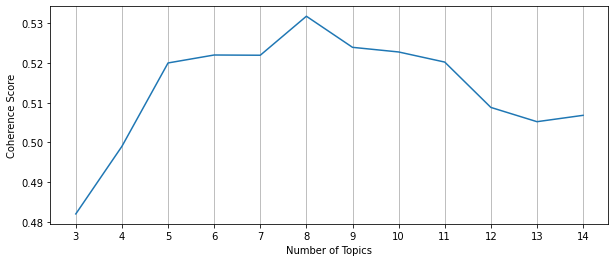

In [109]:
plot_coherence(coherences, kmax, kmin)

---
---
# 6. Mod√®le final<a class="anchor" id="final_model"></a> [‚á™](#menu)

## 6.1 Entrainement & interpr√©tation du meilleur mod√®le LDA <a class="anchor" id="final_model_lda"></a> [‚á™](#menu)

Nous avons vu avec les courbes de coh√©rences que le meilleur choix pour le LDA semble √™tre de chercher **3 sujets** en utilisant le **corpus Bag-Of-Words**.

### Entrainons donc le mod√®le avec le nombre de sujets optimal

In [110]:
selected_num_topics = 3
selected_corpus= corpus_bow
lda_model = LdaMulticore(corpus=selected_corpus, num_topics=selected_num_topics, id2word=dictionary, iterations=100, passes=100, random_state=random_seed)

### Affichons les lemme utilis√©s pour d√©finir les sujets et leur poids

In [111]:
lda_model.print_topics(-1)

[(0,
  '0.025*"order" + 0.017*"wait" + 0.017*"time" + 0.016*"service" + 0.015*"come" + 0.014*"minute" + 0.013*"ask" + 0.013*"place" + 0.012*"go" + 0.012*"say"'),
 (1,
  '0.026*"order" + 0.018*"pizza" + 0.014*"good" + 0.014*"fry" + 0.013*"like" + 0.013*"chicken" + 0.013*"cheese" + 0.012*"place" + 0.011*"burger" + 0.011*"get"'),
 (2,
  '0.021*"good" + 0.019*"place" + 0.011*"like" + 0.011*"restaurant" + 0.011*"service" + 0.009*"price" + 0.009*"taste" + 0.008*"order" + 0.008*"come" + 0.008*"great"')]

### Cherchons les textes qui collent le plus aux sujets pour nous aider √† les interpr√©ter

In [112]:
max_values = {}
max_index = {}
for i in range(len(corpus_bow)):
    row = dict(lda_model[corpus_bow][i])
    
    for j in range(selected_num_topics):
        if row.get(j, 0) > max_values.get(j, 0):
            max_values[j] = row.get(j, 0)
            max_index[j] = i
            
    if i > 500:
        break
        
print(max_values)
print(max_index)

{0: 0.990788, 1: 0.9829053, 2: 0.9888693}
{0: 261, 1: 268, 2: 280}


In [113]:
explore_id = 64  # (0) 43 261 750 6087 (1) 92 268 944 5780 (2) 64 280 746 2843
display(lda_model[corpus_bow][explore_id])
display("-------------", data_bad_reviews['text'][explore_id])
display("-------------", " | ".join(data_bad_reviews['lemmas'][explore_id]))

[(0, 0.014408883), (1, 0.016020782), (2, 0.96957034)]

'-------------'

"One of the worst Italian restaurants I have ever been to in terms of the food.  Ambiance is nice, service was good, but food was awful.  Bland. Pasta was overcooked to the point of mush.  Truffle gnocchi had barely any truffle flavor and, again bland.  A waste of $100 and what was supposed to be a special night out.  There are so many great places in Philly so don't go here."

'-------------'

'bad | italian | restaurant | term | food | ambiance | nice | service | good | food | awful | pasta | overcook | point | mush | truffle | gnocchi | truffle | flavor | bland | waste | suppose | special | night | great | place'

>#### On peut supposer que :
> - le `sujet 0` concerne `la qualit√© du service`.
> - le `sujet 1` concerne `la qualit√© des produits propos√©s`.
> - le `sujet 2` concerne `une d√©ception dans un √©tablissement appr√©ci√©` ou `la qualit√© de la pr√©patation ou conservation`

> ‚ö†Ô∏è Les sujets ne sont pas faciles √† identifier, m√™me en explorant les textes les mieux plac√©s dans ces topics.

## Visualisation du LDA <a class="anchor" id="final_model_lda_vis"></a> [‚á™](#menu)

### Visualisons les sujets avec pyLDAvis

Le graphique `pyLDAvis` ci-dessus repr√©sente les sujets sous forme de cercles, r√©duits en dimmensionalit√© √† l'aide d'une PCA.

Dans l'id√©al, les cercles ne doivent pas se chevaucher et m√™me maximiser la distance entre eux car les sujets les plus proches les uns des autres sont aussi les sujets les plus li√©s (donc les sujets potentiellement redondants). Lorsque l'on clique sur un cercle, les diff√©rents lemmes sont affich√©s √† droite avec leurs fr√©quences dans le corpus en bleu et leurs fr√©quences estim√©es dans le sujet s√©lectionn√© en rouge.

In [114]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus_bow, dictionary)
pyLDAvis.display(lda_display)

>#### On retrouve les id√©es sous-jacentes des topics identifi√©s, mais surtout avec ce graphique, on peut voir que les topics sont correctement s√©par√©s et de taille raisonnablement √©quivalente.

### Visualisons les sujets avec t-SNE

In [115]:
from sklearn.manifold import TSNE
def plot_TSNE_bow(X_ref, y_ref, title='t-SNE'):
    
    X_embedded = TSNE(n_components=2).fit_transform(X_ref)
    dataV=pd.DataFrame(X_embedded, columns=["D1","D2"])
    #dataV['cluster']=model_ref.labels_.tolist()
    dataV['cluster']=y_ref
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(dataV['D1'],dataV['D2'], c=dataV['cluster'], s=50, cmap=cmap_ref, marker='+')
    plt.colorbar(scatter)
    ax.set_title(title)
    ax.set_xlabel('Dimention 1')
    ax.set_ylabel('Dimention 2')
    plt.show()

In [116]:
pd.DataFrame(corpus_bow).shape

(9993, 138)

#### Retrouver l'ID du sujet principal de chaque review

In [117]:
def get_top_id(row):
    max_id = None
    max_va = 0
    for topics in row:
        if topics == None:
            continue
        #print(topics)
        cur_id = topics[0]
        cur_va = topics[1]
        if cur_va > max_va:
            max_va = cur_va
            max_id = cur_id
            
    if math.isclose(max_va, 0.33333, rel_tol=1e-1):
        return selected_num_topics # regular topics are affecter to ID O, 1, 2, ... and filtered reviews are affected to this extra group
    else:
        return max_id

In [118]:
input_pred = pd.DataFrame(lda_model[corpus_bow])
# input_pred.dropna(inplace=True)

In [119]:
main_topics = input_pred.apply(get_top_id, axis=1)

In [120]:
pd.DataFrame(main_topics).value_counts(dropna=False)

0    4768
2    2908
1    2287
3      30
dtype: int64

#### R√©cup√©rons la liste des sujets principaux

In [121]:
encoded_labels = np.array(main_topics.values.tolist(), dtype=np.int32)

#### R√©cup√©rons les bag of words dans un format exploitable par le t-SNE

In [122]:
bows = []
for i in range(len(corpus_bow)):
    select = pd.DataFrame(corpus_bow[i], columns=['index','count'])
    select.set_index('index', inplace=True)
    select = select.reindex(list(range(0,dico_df.shape[0])),fill_value=0)
    bow = [x[0] for x in select.values]
    bows.append(bow)
               
bows_df = pd.DataFrame(bows)

#### Appliquons le t-SNE

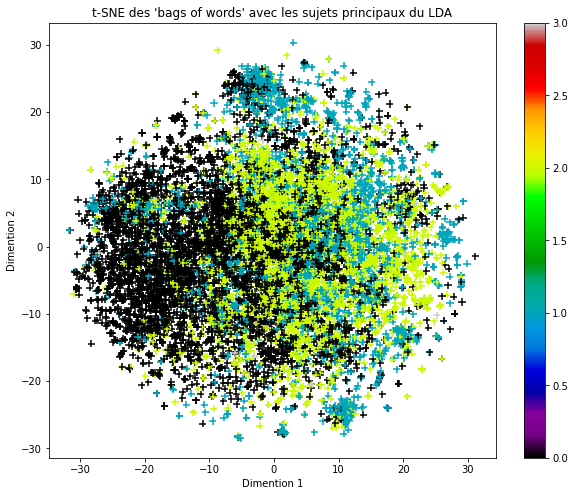

In [123]:
plot_TSNE_bow(bows, encoded_labels, title="t-SNE des 'bags of words' avec les sujets principaux du LDA")

## 6.2 Entrainement & interpr√©tation du meilleur mod√®le NMF <a class="anchor" id="final_model_nmf"></a> [‚á™](#menu)

Nous avons vu avec les courbes de coh√©rences que le meilleur choix pour le NMF semble √™tre de chercher **4 sujets** en utilisant le **corpus Bag-Of-Words**.

### Entrainons donc le mod√®le avec le nombre de sujets optimal

In [137]:
selected_num_topics = 7
selected_corpus = corpus_tfidf
nmf_model = Nmf(corpus=selected_corpus, num_topics=selected_num_topics, id2word=dictionary, passes=100, random_state=random_seed)

### Affichons les lemme utilis√©s pour d√©finir les sujets et leur poids

In [138]:
nmf_model.print_topics(-1)

[(0,
  '0.031*"order" + 0.031*"call" + 0.023*"delivery" + 0.019*"tell" + 0.018*"hour" + 0.017*"phone" + 0.014*"say" + 0.012*"time" + 0.011*"deliver" + 0.010*"pick"'),
 (1,
  '0.033*"table" + 0.019*"server" + 0.019*"seat" + 0.018*"wait" + 0.017*"sit" + 0.013*"reservation" + 0.012*"hostess" + 0.012*"hour" + 0.012*"party" + 0.011*"bar"'),
 (2,
  '0.009*"price" + 0.009*"place" + 0.008*"good" + 0.008*"great" + 0.007*"restaurant" + 0.006*"well" + 0.006*"quality" + 0.006*"eat" + 0.006*"menu" + 0.005*"breakfast"'),
 (3,
  '0.128*"pizza" + 0.020*"crust" + 0.016*"cheese" + 0.009*"topping" + 0.009*"slice" + 0.008*"sauce" + 0.008*"wing" + 0.007*"pepperoni" + 0.007*"dough" + 0.007*"hut"'),
 (4,
  '0.017*"chicken" + 0.017*"burger" + 0.016*"fry" + 0.010*"taste" + 0.009*"sauce" + 0.009*"cheese" + 0.008*"dry" + 0.008*"salad" + 0.008*"flavor" + 0.008*"rice"'),
 (5,
  '0.038*"minute" + 0.031*"drink" + 0.026*"waitress" + 0.024*"wait" + 0.023*"take" + 0.017*"ask" + 0.017*"come" + 0.015*"order" + 0.014*"bri

>#### On peut supposer que :
> - le `sujet 0` concerne `le temps de service / de livraison`.
> - le `sujet 1` concerne `le temps d'attente en salle`.
> - le `sujet 2` concerne `le rapport qualit√© / prix`
> - le `sujet 3` concerne `une d√©ception dans un √©tablissement appr√©ci√©`
> - le `sujet 4` concerne `la qualit√© des produits propos√©s`.
> - le `sujet 5` concerne `la qualit√© des entr√©es / cocktails`
> - le `sujet 6` concerne `le comportement du personnel`

> ‚ö†Ô∏è Les sujets ne sont pas faciles √† identifier, m√™me en explorant les textes les mieux plac√©s dans ces topics.

### Cherchons les textes qui collent le plus aux sujets pour nous aider √† les interpr√©ter

In [155]:
max_values = {}
max_index = {}
for i in range(len(corpus_bow)):
    row = dict(nmf_model[corpus_bow][i])
    
    for j in range(selected_num_topics):
        if row.get(j, 0) > max_values.get(j, 0):
            max_values[j] = row.get(j, 0)
            max_index[j] = i
            
    if i > 100:
        break
        
print(max_values)
print(max_index)

{0: 0.851082827582954, 1: 0.7895752992900076, 4: 0.790946111091095, 5: 0.6305329374545089, 2: 0.8760546670772342, 6: 0.7236061759955519, 3: 0.9386938767900949}
{0: 10, 1: 83, 4: 74, 5: 20, 2: 7, 6: 19, 3: 38}


In [174]:
explore_id = 652  # 0: 1704 736 | 1: 2394 1497 743 | 2: 251 963 | 3: 2049 38 | 4: 170 74 | 5: 3808 841 | 6: 652
display(nmf_model[corpus_bow][explore_id])
display(data_bad_reviews['text'][explore_id])

[(6, 1.0)]

'Was not impressed with the customer service at all. They were not easy to work with and were very rude to us when we used them for an event. Would not recommend.'

## Visualisation du NMF <a class="anchor" id="final_model_nmf_vis"></a> [‚á™](#menu)

### Visualisons les sujets avec t-SNE

#### Retrouver l'ID du sujet principal de chaque review

In [128]:
input_pred = pd.DataFrame(nmf_model[corpus_bow])
# input_pred.dropna(inplace=True)

In [129]:
main_topics = input_pred.apply(get_top_id, axis=1)

In [130]:
pd.DataFrame(main_topics).value_counts(dropna=False)

7    1833
1    1608
4    1453
2    1296
0    1109
5    1089
6     892
3     713
dtype: int64

#### R√©cup√©rons la liste des sujets principaux

In [131]:
encoded_labels = np.array(main_topics.values.tolist(), dtype=np.int32)

#### R√©cup√©rons les bag of words dans un format exploitable par le t-SNE

In [132]:
bows = []
for i in range(len(corpus_bow)):
    select = pd.DataFrame(corpus_bow[i], columns=['index','count'])
    select.set_index('index', inplace=True)
    select = select.reindex(list(range(0,dico_df.shape[0])),fill_value=0)
    bow = [x[0] for x in select.values]
    bows.append(bow)
               
bows_df = pd.DataFrame(bows)

#### Appliquons le t-SNE

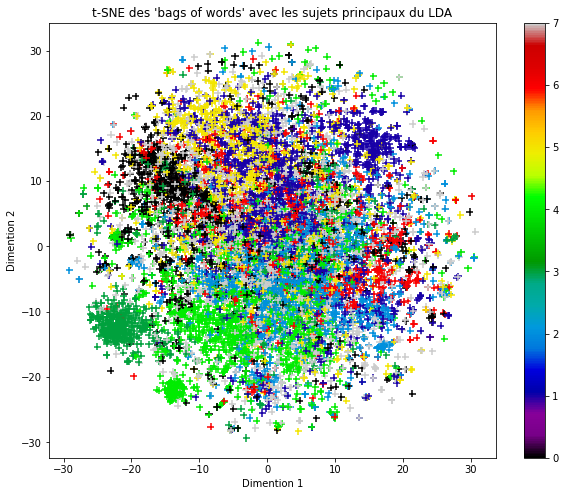

In [133]:
plot_TSNE_bow(bows, encoded_labels, title="t-SNE des 'bags of words' avec les sujets principaux du LDA")

## 6.3 Export du mod√®le s√©lectionn√© <a class="anchor" id="final_model_export"></a> [‚á™](#menu)

>#### Au final, j'ai d√©cid√© d'utiliser **le mod√®le LDA**:
> - c'est celui qui me semble le plus coh√©rent d'un point de vue des topics propos√©s
> - il a un score de coh√©rence inf√©rieur, mais proche malgr√© tout de celui du NMF
> - il est plus facile √† visualiser √† l'aide de pyLDAvis (il aurait fallu faire le NMF avec sklearn pour pouvoir faire la m√™me chose, mais j'ai utilis√© gensim...), ce qui est utile ici puisque l'on veut **montrer** nos r√©sultats.

In [135]:
import joblib

topics = {
    0: "La qualit√© du service",
    1: "La qualit√© des produits propos√©s",
    2: "Une d√©ception dans un √©tablissement appr√©ci√©",
}

joblib.dump((dictionary, lda_model, topics), os.path.join("models", "lda.pipeline"))
joblib.dump((dictionary, lda_model, topics, corpus_bow), os.path.join("models", "lda_vis.pipeline"))

['models/lda_vis.pipeline']

#### Tests du pipeline pour l'export LDA

#### Tests du pipeline pour l'export NMF

---
---
# Pistes d'Am√©lioration

- Utiliser des Bigrams et Trigrams
- Supprimer les Hotels (certains √©tablissement font Restaurant & Hotel)